# [Dataquest Tutorial](https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/)

[Open Power System Data](https://open-power-system-data.org/)

From a [post](https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/) by [Jennifer Walker](https://www.dataquest.io/blog/author/jennifer/)

Electricity production and consumption are reported as daily totals in gigawatt-hours (GWh). The columns of the data file are:

- Date — The date (yyyy-mm-dd format)
- Consumption — Electricity consumption in GWh
- Wind — Wind power production in GWh
- Solar — Solar power production in GWh
- Wind+Solar — Sum of wind and solar power production in GWh


## Time series data structures

Before we dive into the OPSD data, let’s briefly introduce the main pandas data structures for working with dates and times. In pandas, a single point in time is represented as a `Timestamp`. We can use the `to_datetime()` function to create Timestamps from strings in a wide variety of date/time formats. Let’s import pandas and convert a few dates and times to Timestamps.

In [1]:
import pandas as pd
pd.to_datetime('2018-01-15 3:45pm')

Timestamp('2018-01-15 15:45:00')

In [2]:
pd.to_datetime('7/8/1952')

Timestamp('1952-07-08 00:00:00')

In [3]:
pd.to_datetime('7/8/1952', dayfirst=True)

Timestamp('1952-08-07 00:00:00')

If we supply a list or array of strings as input to `to_datetime()`, it returns a sequence of date/time values in a DatetimeIndex object, which is the core data structure that powers much of pandas time series functionality.

In [4]:
pd.to_datetime(['2018-01-05', '7/8/1952', 'Oct 10, 1995'])

DatetimeIndex(['2018-01-05', '1952-07-08', '1995-10-10'], dtype='datetime64[ns]', freq=None)

In the `DatetimeIndex` above, the data type `datetime64[ns]` indicates that the underlying data is stored as **64-bit integers, in units of nanoseconds (ns)**. This data structure allows pandas to compactly store large sequences of date/time values and efficiently perform vectorized operations using [NumPy `datetime64` arrays](https://docs.scipy.org/doc/numpy-1.15.0/reference/arrays.datetime.html).

If we’re dealing with a sequence of strings all in the same date/time format, we can explicitly specify it with the `format` parameter. For very large data sets, this can greatly speed up the performance of `to_datetime()` compared to the default behavior, where the format is inferred separately for each individual string. Any of the [format codes](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) from the `strftime()` and `strptime()` functions in Python’s built-in `datetime` module can be used. The example below uses the format codes `%m`(numeric month), `%d` (day of month), and `%y` (2-digit year) to specify the format.

In [5]:
pd.to_datetime(['2/25/10', '8/6/17', '12/15/12'], format='%m/%d/%y')

DatetimeIndex(['2010-02-25', '2017-08-06', '2012-12-15'], dtype='datetime64[ns]', freq=None)

## Creating a time series DataFrame
To work with time series data in pandas, we use a `DatetimeIndex` as the index for our `DataFrame` (or Series). Let’s see how to do this with our OPSD data set. First, we use the `read_csv()` function to read the data into a `DataFrame`, and then display its shape.

In [6]:
opsd_daily = pd.read_csv('opsd_germany_daily.csv')
opsd_daily.shape

(4383, 5)

In [7]:
opsd_daily.head(3)

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN


In [8]:
opsd_daily.tail(3)

,Date,Consumption,Wind,Solar,Wind+Solar
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714
4382,2017-12-31,1107.11488,721.176,19.980,741.156


In [9]:
opsd_daily.dtypes

Date            object
Consumption    float64
Wind           float64
Solar          float64
Wind+Solar     float64
dtype: object

**The tutorial did not mention the next step**

In [10]:
opsd_daily['Date'] = pd.to_datetime(opsd_daily['Date'])

In [11]:
opsd_daily.dtypes

Date           datetime64[ns]
Consumption           float64
Wind                  float64
Solar                 float64
Wind+Solar            float64
dtype: object

In [12]:
opsd_daily = opsd_daily.set_index('Date')

In [13]:
opsd_daily.head(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN


In [14]:
opsd_daily.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq=None)

Alternatively, we can consolidate the above steps into a single line, using the index_col and parse_dates parameters of the read_csv() function. This is often a useful shortcut.

In [15]:
opsd_daily = pd.read_csv('opsd_germany_daily.csv', index_col=0, parse_dates=True)

In [16]:
opsd_daily.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq=None)

Another useful aspect of the DatetimeIndex is that the individual date/time components are all available as attributes such as year, month, day, and so on. Let’s add a few more columns to opsd_daily, containing the year, month, and weekday name.

**Tutorial uses weekday_name which does not exist**

In [17]:
opsd_daily['Year'] = opsd_daily.index.year
opsd_daily['Month'] = opsd_daily.index.month
opsd_daily['Weekday Name'] = opsd_daily.index.day_name()
opsd_daily.sample(5, random_state=0)

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2008-08-23,1152.011,NaN,NaN,NaN,2008,8,Saturday
2013-08-08,1291.984,79.666,93.371,173.037,2013,8,Thursday
2009-08-27,1281.057,NaN,NaN,NaN,2009,8,Thursday
2015-10-02,1391.050,81.229,160.641,241.870,2015,10,Friday
2009-06-02,1201.522,NaN,NaN,NaN,2009,6,Tuesday


## Time-based indexing

One of the most powerful and convenient features of pandas time series is time-based indexing — using dates and times to intuitively organize and access our data. With time-based indexing, we can use date/time formatted strings to select data in our `DataFrame` with the `loc` accessor. The indexing works similar to standard label-based indexing with `loc`, but with a few additional features.

In [18]:
opsd_daily.loc['2017-08-10']

Consumption     1351.491
Wind             100.274
Solar              71.16
Wind+Solar       171.434
Year                2017
Month                  8
Weekday Name    Thursday
Name: 2017-08-10 00:00:00, dtype: object

We can also select a slice of days, such as ``'2014-01-20':'2014-01-22'`. As with regular label-based indexing with `loc`, the slice is inclusive of both endpoints.

In [19]:
opsd_daily.loc['2014-01-20':'2014-01-22']

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2014-01-20,1590.687,78.647,6.371,85.018,2014,1,Monday
2014-01-21,1624.806,15.643,5.835,21.478,2014,1,Tuesday
2014-01-22,1625.155,60.259,11.992,72.251,2014,1,Wednesday


Another very handy feature of pandas time series is partial-string indexing, where we can select all date/times which partially match a given string. For example, we can select the entire year 2006 with `opsd_daily.loc['2006']`, or the entire month of February 2012 with `opsd_daily.loc['2012-02']`.

In [20]:
opsd_daily.loc['2012-02']

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2012-02-01,1511.866,199.607,43.502,243.109,2012,2,Wednesday
2012-02-02,1563.407,73.469,44.675,118.144,2012,2,Thursday
2012-02-03,1563.631,36.352,46.510,82.862,2012,2,Friday
2012-02-04,1372.614,20.551,45.225,65.776,2012,2,Saturday
2012-02-05,1279.432,55.522,54.572,110.094,2012,2,Sunday
2012-02-06,1574.766,34.896,55.389,90.285,2012,2,Monday
2012-02-07,1615.078,100.312,19.867,120.179,2012,2,Tuesday
2012-02-08,1613.774,93.763,36.930,130.693,2012,2,Wednesday
2012-02-09,1591.532,132.219,19.042,151.261,2012,2,Thursday


## Visualizing time series data

In [21]:
import matplotlib.pyplot as plt

In [22]:
try:
  import seaborn as sns
except:
  !pip install seaborn
  import seaborn as sns

In [23]:
sns.set(rc={'figure.figsize':(11,4)})

<AxesSubplot: xlabel='Date'>

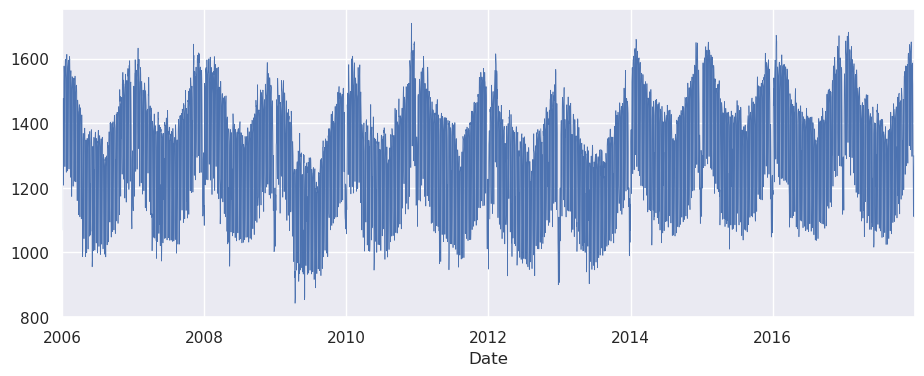

In [24]:
opsd_daily['Consumption'].plot(linewidth=0.5)

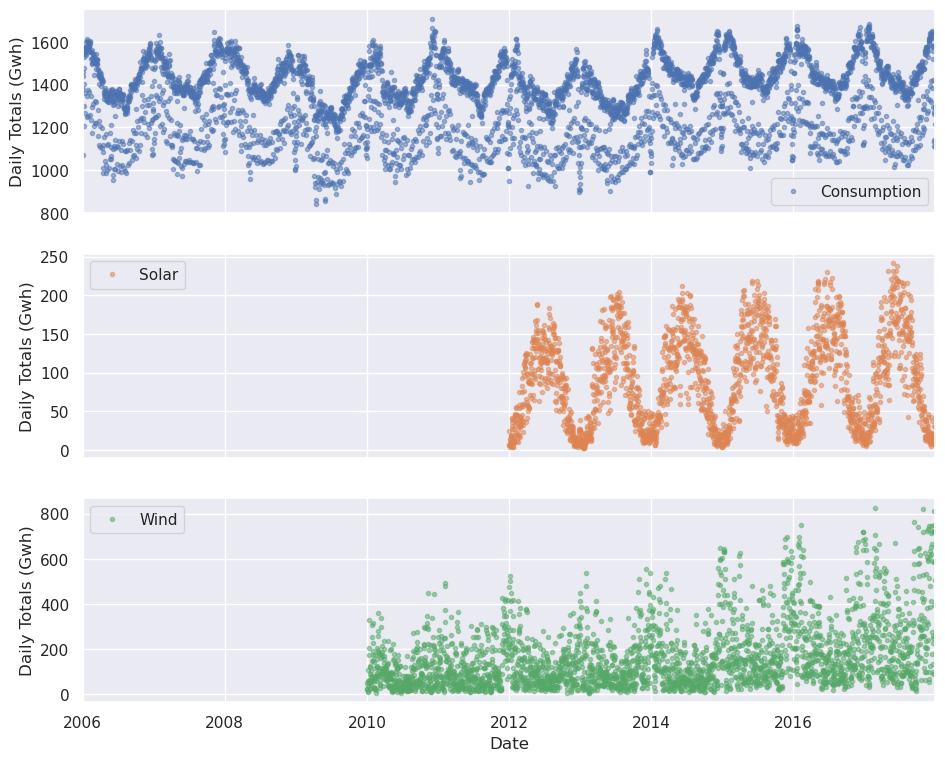

In [25]:
cols_plot = ['Consumption', 'Solar', 'Wind']
axes = opsd_daily[cols_plot].plot(marker='.', 
                                  alpha=0.5,
                                  linestyle='None',
                                  figsize=(11,9),
                                  subplots=True)
for ax in axes:
  ax.set_ylabel('Daily Totals (Gwh)')

All three time series clearly exhibit periodicity—often referred to as seasonality in time series analysis—in which a pattern repeats again and again at regular time intervals. The Consumption, Solar, and Wind time series oscillate between high and low values on a yearly time scale, corresponding with the seasonal changes in weather over the year. However, seasonality in general does not have to correspond with the meteorological seasons. For example, retail sales data often exhibits yearly seasonality with increased sales in November and December, leading up to the holidays.

Seasonality can also occur on other time scales. The plot above suggests there may be some weekly seasonality in Germany’s electricity consumption, corresponding with weekdays and weekends. Let’s plot the time series in a single year to investigate further.

Text(0, 0.5, 'Daily Consumption (GWh)')

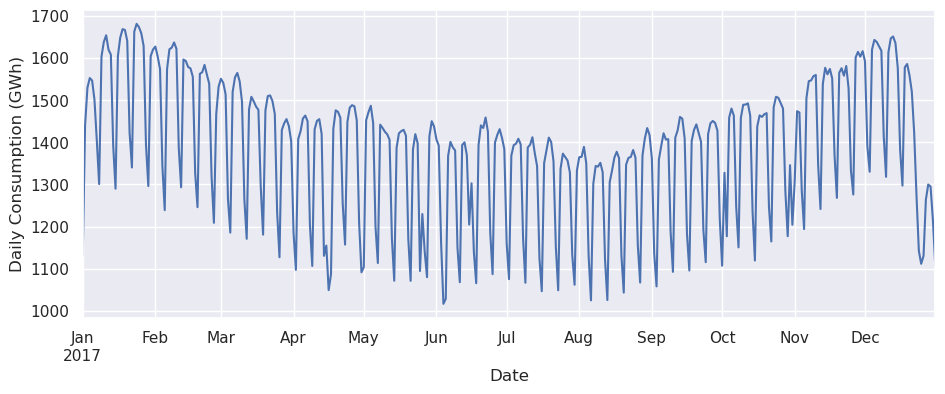

In [26]:
ax = opsd_daily.loc['2017', 'Consumption'].plot()
ax.set_ylabel('Daily Consumption (GWh)')

Now we can clearly see the weekly oscillations. Another interesting feature that becomes apparent at this level of granularity is the drastic decrease in electricity consumption in early January and late December, during the holidays.

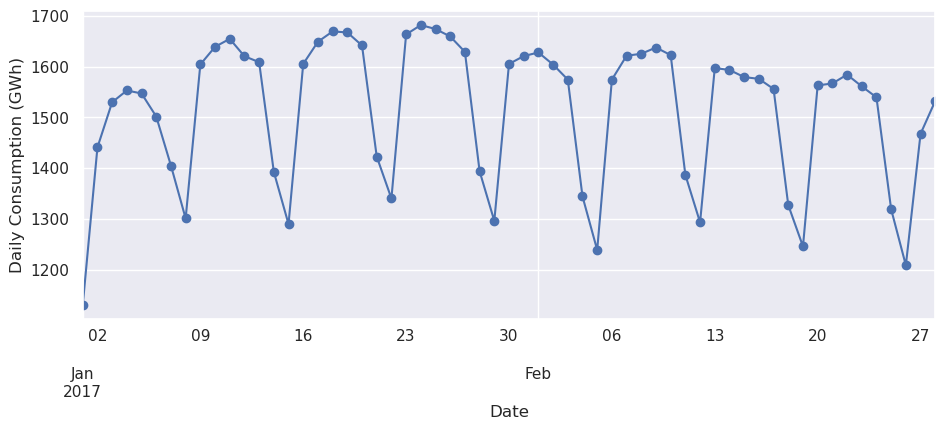

In [27]:
ax = opsd_daily.loc['2017-01':'2017-02', 'Consumption'].plot(marker='o', linestyle='-')
ax.set_ylabel('Daily Consumption (GWh)');

## Customizing time series plots

To better visualize the weekly seasonality in electricity consumption in the plot above, it would be nice to have vertical gridlines on a weekly time scale (instead of on the first day of each month). We can customize our plot with matplotlib.dates, so let’s import that module.

In [28]:
import matplotlib.dates as mdates

Because date/time ticks are handled a bit differently in matplotlib.dates compared with the DataFrame’s `plot()` method, let’s create the plot directly in matplotlib. Then we use `mdates.WeekdayLocator()` and `mdates.MONDAY` to set the x-axis ticks to the first Monday of each week. We also use `mdates.DateFormatter()` to improve the formatting of the tick labels, using the format codes we saw earlier.

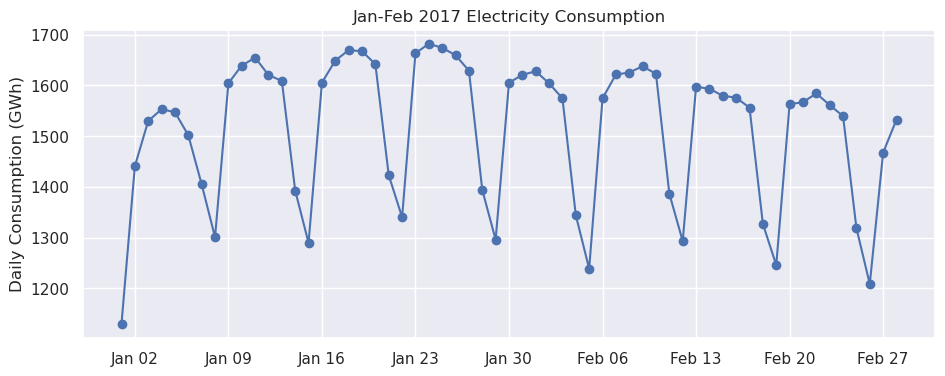

In [29]:
fig, ax = plt.subplots()
ax.plot(opsd_daily.loc['2017-01':"2017-02", 'Consumption'],
        marker='o',
        linestyle='-')
ax.set_ylabel('Daily Consumption (GWh)')
ax.set_title('Jan-Feb 2017 Electricity Consumption')
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

## Seasonality

Next, let’s further explore the seasonality of our data with box plots, using seaborn’s boxplot() function to group the data by different time periods and display the distributions for each group. We’ll first group the data by month, to visualize yearly seasonality.

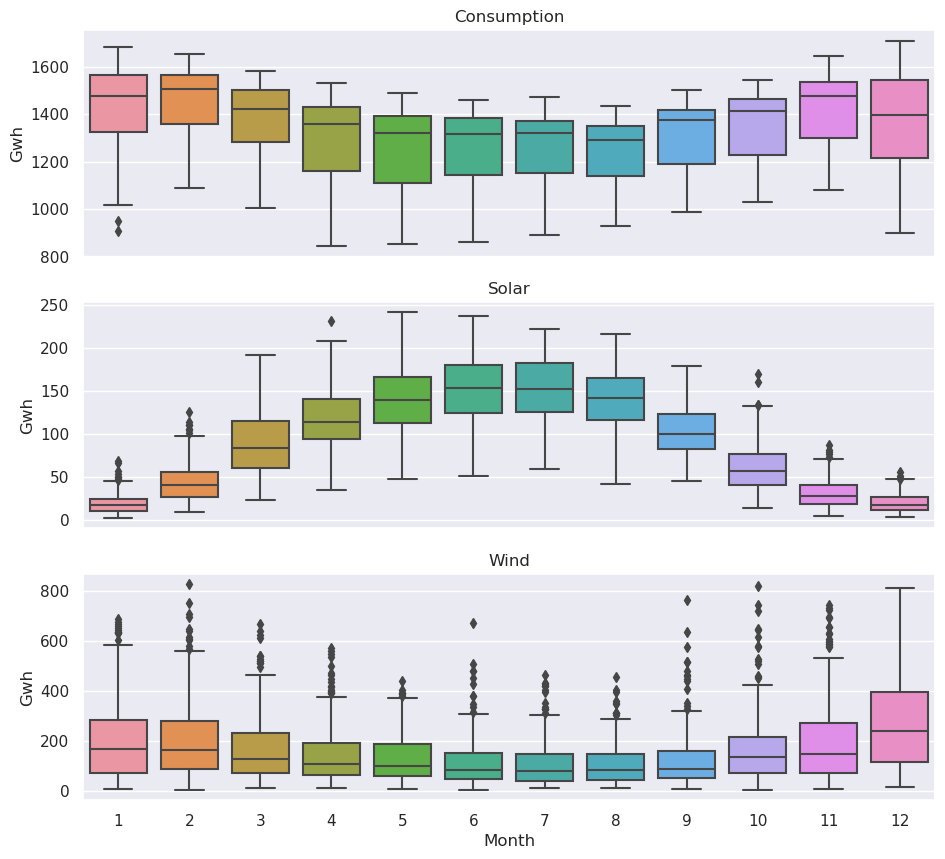

In [30]:
fig, axes = plt.subplots(3, 1, figsize=(11,10),sharex=True)
for name, ax in zip(['Consumption', 'Solar', 'Wind'], axes):
  sns.boxplot(data=opsd_daily, x='Month', y=name, ax=ax)
  ax.set_ylabel('Gwh')
  ax.set_title(name)
  ax.set_xlabel('')
# Remove the automatic x-axis label from all but the bottom subplot
# For some reason Leaving xlabel as default and then "unsetting" it as 
# described in the article with != logic didn't work
if ax == axes[-1]:
  ax.set_xlabel('Month')

<AxesSubplot: xlabel='Weekday Name', ylabel='Consumption'>

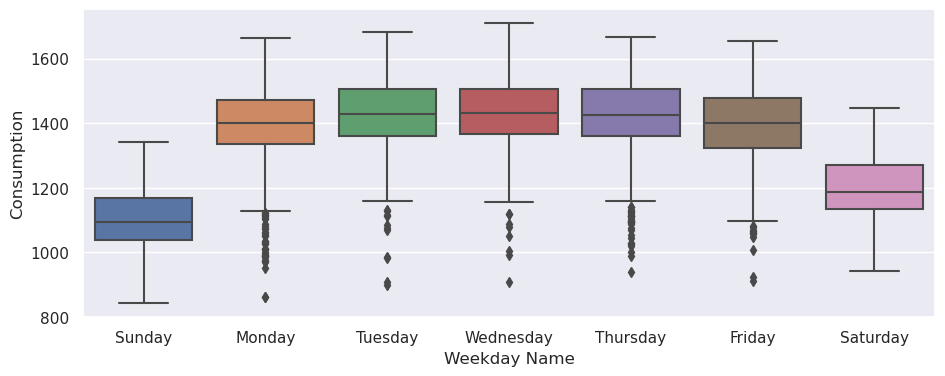

In [31]:
sns.boxplot(data=opsd_daily, x='Weekday Name', y='Consumption')

This section has provided a brief introduction to time series seasonality. As we will see later, applying a rolling window to the data can also help to visualize seasonality on different time scales. Other techniques for analyzing seasonality include autocorrelation plots, which plot the correlation coefficients of the time series with itself at different time lags.

Time series with strong seasonality can often be well represented with models that decompose the signal into seasonality and a long-term trend, and these models can be used to forecast future values of the time series. A simple example of such a model is [classical seasonal decomposition](https://otexts.org/fpp2/classical-decomposition.html), as demonstrated in [this tutorial](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/). A more sophisticated example is as Facebook’s [Prophet model](https://facebook.github.io/prophet/), which uses curve fitting to decompose the time series, taking into account seasonality on multiple time scales, holiday effects, abrupt changepoints, and long-term trends, as demonstrated in [this tutorial](https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a).

## Frequencies

When the data points of a time series are uniformly spaced in time (e.g., hourly, daily, monthly, etc.), the time series can be associated with a frequency in pandas. For example, let’s use the `date_range()` function to create a sequence of uniformly spaced dates from 1998-03-10 through 1998-03-15 at daily frequency.

In [32]:
pd.date_range('1998-03-10', '1998-03-15', freq='D')

DatetimeIndex(['1998-03-10', '1998-03-11', '1998-03-12', '1998-03-13',
               '1998-03-14', '1998-03-15'],
              dtype='datetime64[ns]', freq='D')

The resulting DatetimeIndex has an attribute freq with a value of 'D', indicating daily frequency. Available frequencies in pandas include hourly ('H'), calendar daily ('D'), business daily ('B'), weekly ('W'), monthly ('M'), quarterly ('Q'), annual ('A'), and [many others](https://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases). Frequencies can also be specified as multiples of any of the base frequencies, for example '5D' for every five days.

In [33]:
pd.date_range('2004-09-20', periods=8, freq='H')

DatetimeIndex(['2004-09-20 00:00:00', '2004-09-20 01:00:00',
               '2004-09-20 02:00:00', '2004-09-20 03:00:00',
               '2004-09-20 04:00:00', '2004-09-20 05:00:00',
               '2004-09-20 06:00:00', '2004-09-20 07:00:00'],
              dtype='datetime64[ns]', freq='H')

In [34]:
opsd_daily.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq=None)

If we know that our data should be at a specific frequency, we can use the DataFrame’s `asfreq()` method to assign a frequency. If any date/times are missing in the data, new rows will be added for those date/times, which are either empty (NaN), or filled according to a specified data filling method such as forward filling or interpolation.

In [88]:
times_sample = pd.to_datetime(['2013-02-03', '2013-02-06', '2013-02-08'])
consum_sample = opsd_daily.loc[times_sample, ['Consumption']]
consum_sample

,Consumption
2013-02-03,1109.639
2013-02-06,1451.449
2013-02-08,1433.098


In [ ]:
opse_daily.query('')

Now we use the `asfreq()` method to convert the DataFrame to daily frequency, with a column for unfilled data, and a column for forward filled data.

In [91]:
consum_freq = consum_sample.asfreq('D')
consum_freq['Consumption = Forward Fill'] = consum_sample.asfreq('D', method='ffill')
consum_freq

,Consumption,Consumption = Forward Fill
2013-02-03,1109.639,1109.639
2013-02-04,NaN,1109.639
2013-02-05,NaN,1109.639
2013-02-06,1451.449,1451.449
2013-02-07,NaN,1451.449
2013-02-08,1433.098,1433.098


## Resampling

It is often useful to **resample** our time series data to a lower or higher frequency. Resampling to a lower frequency (**downsampling**) usually involves an aggregation operation — for example, computing monthly sales totals from daily data. The daily OPSD data we’re working with in this tutorial was downsampled from the [original hourly time series](https://github.com/jenfly/opsd/blob/master/time-series-preprocessing.ipynb). Resampling to a higher frequency (upsampling) is less common and often involves interpolation or other data filling method — for example, interpolating hourly weather data to 10 minute intervals for input to a scientific model.

We will focus here on downsampling, exploring how it can help us analyze our OPSD data on various time scales. We use the DataFrame’s `resample()` method, which splits the `DatetimeIndex` into time bins and groups the data by time bin. The `resample()` method returns a [Resampler object](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html), similar to a pandas [GroupBy object](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html#pandas.DataFrame.groupby). We can then apply an aggregation method such as `mean()`, `median()`, `sum()`, etc., to the data group for each time bin.

In [94]:
data_columns = ['Consumption', 'Wind', 'Solar', 'Wind+Solar']
opsd_weekly_mean = opsd_daily[data_columns].resample('W').mean()
opsd_weekly_mean.head(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184000,NaN,NaN,NaN
2006-01-08,1381.300143,NaN,NaN,NaN
2006-01-15,1486.730286,NaN,NaN,NaN


By construction, our weekly time series has 1/7 as many data points as the daily time series. We can confirm this by comparing the number of rows of the two DataFrames.

In [95]:
print(opsd_daily.shape[0])
print(opsd_weekly_mean.shape[0])

4383
627


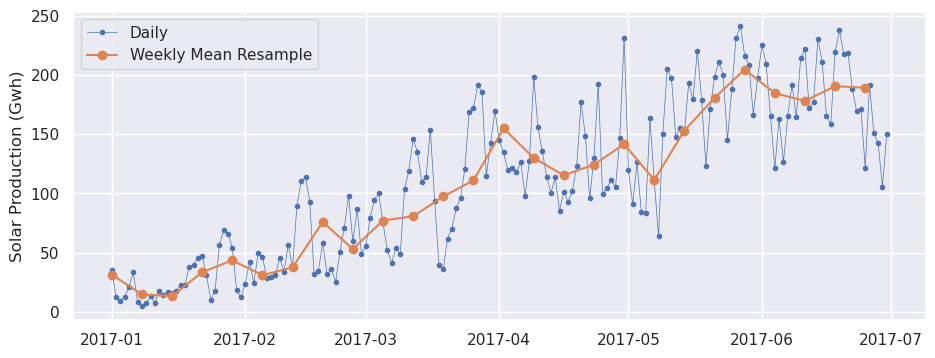

In [96]:
start, end = '2017-01', '2017-06'
fig, ax = plt.subplots()
ax.plot(opsd_daily.loc[start:end, 'Solar'],
        marker='.',
        linestyle='-', 
        linewidth=0.5, 
        label='Daily')
ax.plot(opsd_weekly_mean.loc[start:end, 'Solar'],
        marker='o',
        linestyle='-',
        label="Weekly Mean Resample")
ax.set_ylabel('Solar Production (Gwh)')
ax.legend()

Now let’s resample the data to monthly frequency, aggregating with sum totals instead of the mean. Unlike aggregating with `mean()`, which sets the output to `NaN` for any period with all missing data, the default behavior of `sum()` will return output of `0` as the sum of missing data. We use the min_count parameter to change this behavior.

In [97]:
opsd_monthly = opsd_daily[data_columns].resample('M').sum(min_count=28)
opsd_monthly.head(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-31,45304.704,NaN,NaN,NaN
2006-02-28,41078.993,NaN,NaN,NaN
2006-03-31,43978.124,NaN,NaN,NaN


You might notice that the monthly resampled data is labelled with the end of each month (the right bin edge), whereas the weekly resampled data is labelled with the left bin edge. **By default, resampled data is labelled with the right bin edge for monthly, quarterly, and annual frequencies, and with the left bin edge for all other frequencies**. This behavior and various other options can be adjusted using the parameters listed in the `resample()` documentation.

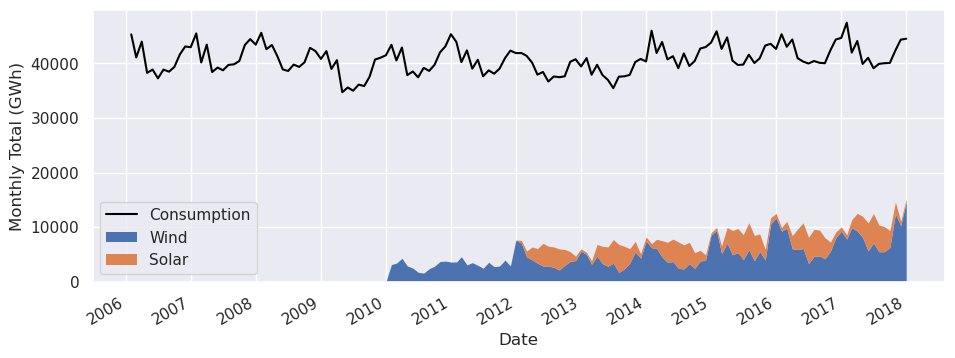

In [98]:
fig, ax = plt.subplots()
ax.plot(opsd_monthly['Consumption'], color='black', label='Consumption')
opsd_monthly[['Wind', 'Solar']].plot.area(ax=ax, linewidth=0)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_ylabel('Monthly Total (GWh)');

In [99]:
# Compute the annual sums, setting the value to NaN for any year which has
# fewer than 360 days of data
opsd_annual = opsd_daily[data_columns].resample('A').sum(min_count=360)
# The default index of the resampled DataFrame is the last day of each year,
# ('2006-12-31', '2007-12-31', etc.) so to make life easier, set the index
# to the year component
opsd_annual = opsd_annual.set_index(opsd_annual.index.year)
opsd_annual.index.name = 'Year'
# Compute the ratio of Wind+Solar to Consumption
opsd_annual['Wind+Solar/Consumption'] = opsd_annual['Wind+Solar'] / opsd_annual['Consumption']
opsd_annual.tail(3)

,Consumption,Wind,Solar,Wind+Solar,Wind+Solar/Consumption
Year,,,,,
2015,505264.56300,77468.994,34907.138,112376.132,0.222410
2016,505927.35400,77008.126,34562.824,111570.950,0.220528
2017,504736.36939,102667.365,35882.643,138550.008,0.274500


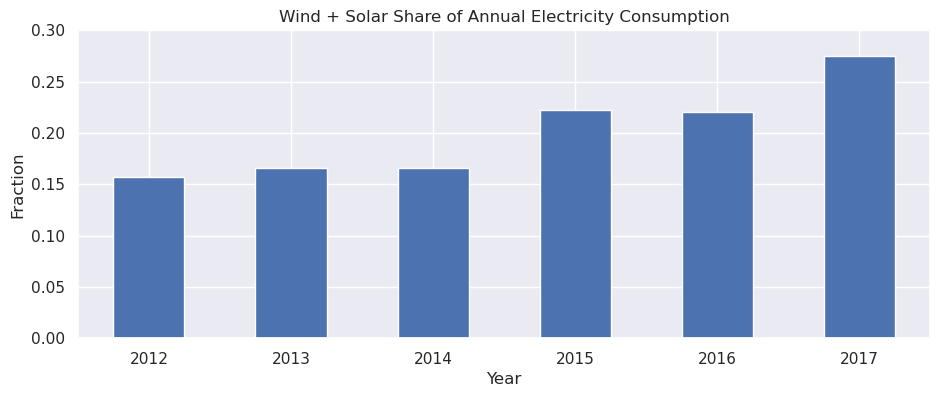

In [100]:
# Plot from 2012 onwards, because there is no solar production data in earlier years
ax = opsd_annual.loc[2012:, 'Wind+Solar/Consumption'].plot.bar(color='C0')
ax.set_ylabel('Fraction')
ax.set_ylim(0, 0.3)
ax.set_title('Wind + Solar Share of Annual Electricity Consumption')
plt.xticks(rotation=0);

## Rolling windows

Rolling window operations are another important transformation for time series data. Similar to downsampling, rolling windows split the data into time windows and and the data in each window is aggregated with a function such as `mean()`, `median()`, `sum()`, etc. However, unlike downsampling, where the time bins do not overlap and the output is at a lower frequency than the input, rolling windows overlap and “roll” along at the same frequency as the data, so the transformed time series is at the same frequency as the original time series.

By default, all data points within a window are equally weighted in the aggregation, but this can be changed by specifying window types such as Gaussian, triangular, and others. We’ll stick with the standard equally weighted window here.

Let’s use the rolling() method to compute the 7-day rolling mean of our daily data. We use the center=True argument to label each window at its midpoint, so the rolling windows are:

- `2006-01-01` to `2006-01-07` — labelled as `2006-01-04`
- `2006-01-02` to `2006-01-08` — labelled as `2006-01-05`
- `2006-01-03` to `2006-01-09` — labelled as `2006-01-06`
- and so on...

In [101]:
# Compute the centered 7-day rolling mean
opsd_7d = opsd_daily[data_columns].rolling(7, center=True).mean()
opsd_7d.head(10)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,NaN,NaN,NaN,NaN
2006-01-02,NaN,NaN,NaN,NaN
2006-01-03,NaN,NaN,NaN,NaN
2006-01-04,1361.471429,NaN,NaN,NaN
2006-01-05,1381.300143,NaN,NaN,NaN
2006-01-06,1402.557571,NaN,NaN,NaN
2006-01-07,1421.754429,NaN,NaN,NaN
2006-01-08,1438.891429,NaN,NaN,NaN
2006-01-09,1449.769857,NaN,NaN,NaN


To visualize the differences between rolling mean and resampling, let’s update our earlier plot of January-June 2017 solar power production to include the 7-day rolling mean along with the weekly mean resampled time series and the original daily data.

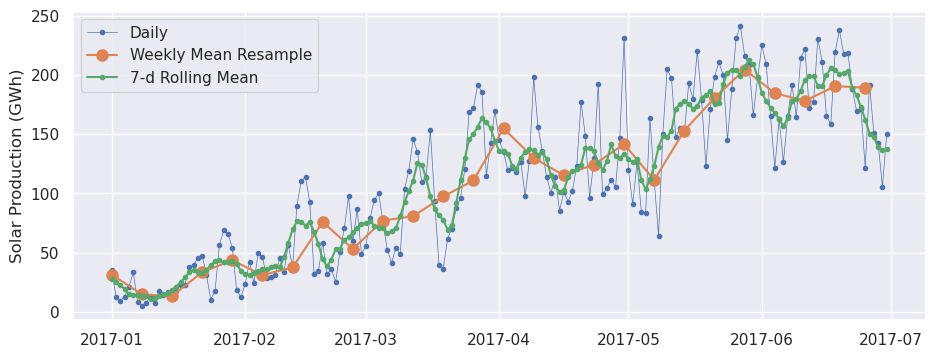

In [103]:
start, end = '2017-01', '2017-06'
fig, ax = plt.subplots()
ax.plot(opsd_daily.loc[start:end, 'Solar'],
        marker='.',
        linestyle='-',
        linewidth=0.5,
        label='Daily')
ax.plot(opsd_weekly_mean.loc[start:end, 'Solar'],
        marker='o',
        markersize=8,
        linestyle='-',
        label='Weekly Mean Resample')
ax.plot(opsd_7d.loc[start:end, 'Solar'],
        marker='.',
        linestyle='-',
        label='7-d Rolling Mean')
ax.set_ylabel('Solar Production (GWh)')
ax.legend();

We can see that data points in the rolling mean time series have the same spacing as the daily data, but the curve is smoother because higher frequency variability has been averaged out. In the rolling mean time series, the peaks and troughs tend to align closely with the peaks and troughs of the daily time series. In contrast, the peaks and troughs in the weekly resampled time series are less closely aligned with the daily time series, since the resampled time series is at a coarser granularity.

## Trends
Time series data often exhibit some slow, gradual variability in addition to higher frequency variability such as seasonality and noise. An easy way to visualize these trends is with rolling means at different time scales.

A rolling mean tends to smooth a time series by averaging out variations at frequencies much higher than the window size and averaging out any seasonality on a time scale equal to the window size. This allows lower-frequency variations in the data to be explored. Since our electricity consumption time series has weekly and yearly seasonality, let’s look at rolling means on those two time scales.

In [104]:
opsd_365d = opsd_daily[data_columns].rolling(window=365, 
                                             center=True,
                                             min_periods=360).mean()

Text(0.5, 1.0, 'Trends in Electricity Consumption')

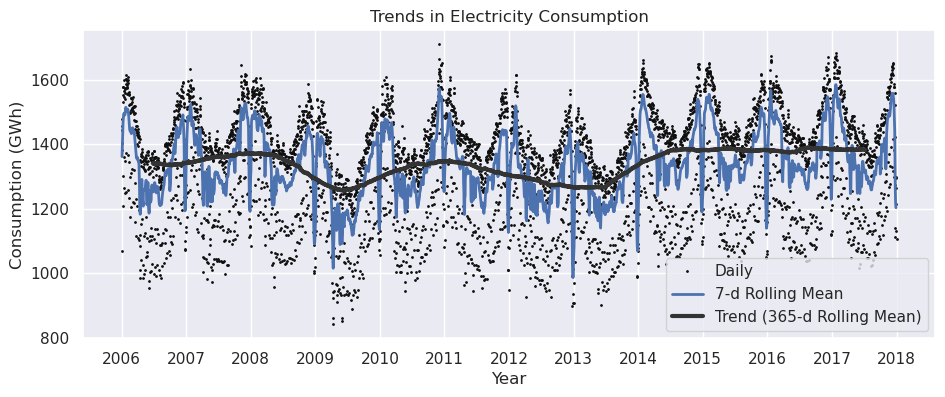

In [105]:
fig, ax = plt.subplots()
ax.plot(opsd_daily['Consumption'],
        marker='.',
        markersize=2,
        color='.06',
        linestyle='None',
        label='Daily')
ax.plot(opsd_7d['Consumption'],
        linewidth=2,
        label='7-d Rolling Mean')
ax.plot(opsd_365d['Consumption'],
        color='0.2',
        linewidth=3,
        label='Trend (365-d Rolling Mean)')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Consumption (GWh)')
ax.set_title('Trends in Electricity Consumption')

We can see that the 7-day rolling mean has smoothed out all the weekly seasonality, while preserving the yearly seasonality. The 7-day rolling mean reveals that while electricity consumption is typically higher in winter and lower in summer, there is a dramatic decrease for a few weeks every winter at the end of December and beginning of January, during the holidays.

Looking at the 365-day rolling mean time series, we can see that the long-term trend in electricity consumption is pretty flat, with a couple of periods of anomalously low consumption around 2009 and 2012-2013.

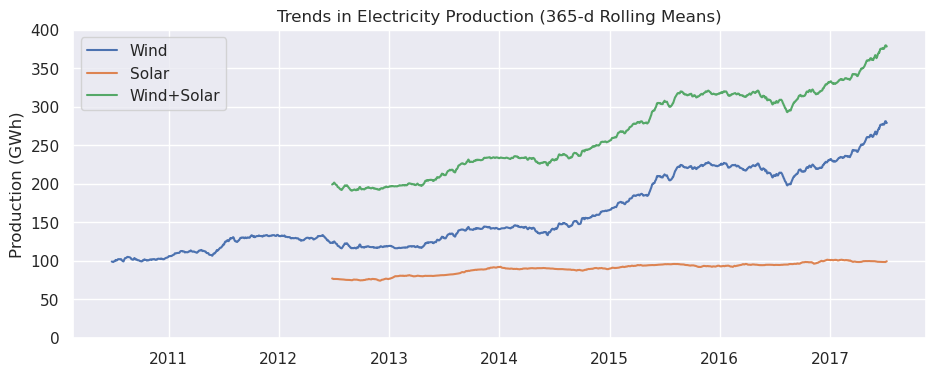

In [107]:
fig, ax = plt.subplots()
for nm in ['Wind', 'Solar', 'Wind+Solar']:
  ax.plot(opsd_365d[nm], label=nm)
  ax.xaxis.set_major_locator(mdates.YearLocator())
  ax.set_ylim(0,400)
  ax.legend()
  ax.set_ylabel('Production (GWh)')
  ax.set_title('Trends in Electricity Production (365-d Rolling Means)')

## Summary and further reading

We’ve learned how to wrangle, analyze, and visualize our time series data in pandas using techniques such as time-based indexing, resampling, and rolling windows. Applying these techniques to our OPSD data set, we’ve gained insights on seasonality, trends, and other interesting features of electricity consumption and production in Germany.

Other potentially useful topics we haven’t covered include [time zone handling](https://pandas.pydata.org/pandas-docs/stable/timeseries.html#time-zone-handling) and [time shifts](https://pandas.pydata.org/pandas-docs/stable/timeseries.html#shifting-lagging). If you’d like to learn more about working with time series data in pandas, you can check out [this section](https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html) of the Python Data Science Handbook, this [blog post](https://tomaugspurger.github.io/modern-7-timeseries), and of course the [official documentation](https://pandas.pydata.org/pandas-docs/stable/timeseries.html).